In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, mean_absolute_error

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

import warnings
warnings.filterwarnings('ignore') #경고 무시

# 시계열 데이터 준비

In [3]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [4]:
ts = df['Close']

print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [5]:
def getData(filepath):
    dataset_filepath = os.getenv('HOME') + filepath
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

    ts = df['Close']
    
    return ts

### Close 데이터 확인

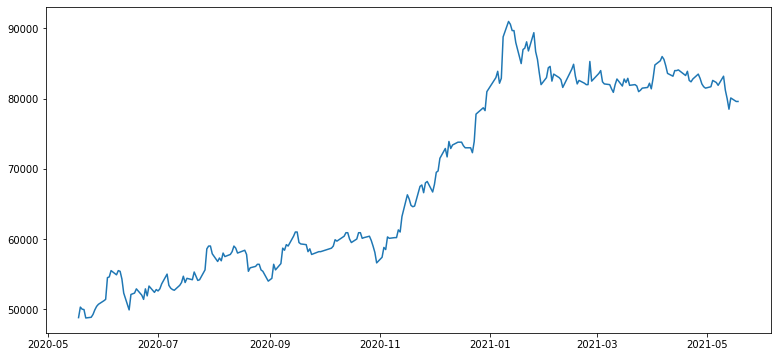

In [6]:
plt.plot(ts)

### 결측치 처리

In [7]:
ts = ts.interpolate(method='time')
print(ts[ts.isna()])

Series([], Name: Close, dtype: float64)


### 로그 변환

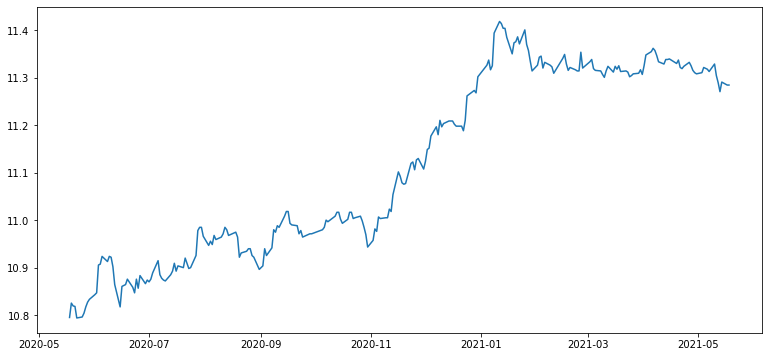

In [8]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [9]:
def preprocessing(ts):
    ts = ts.interpolate(method='time')
    print(ts[ts.isna()])
    
    ts_log = np.log(ts)
    
    return ts_log

---

# 시계열 안정성 분석

### 함수 정의

In [10]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

### 정성적 그래프 분석

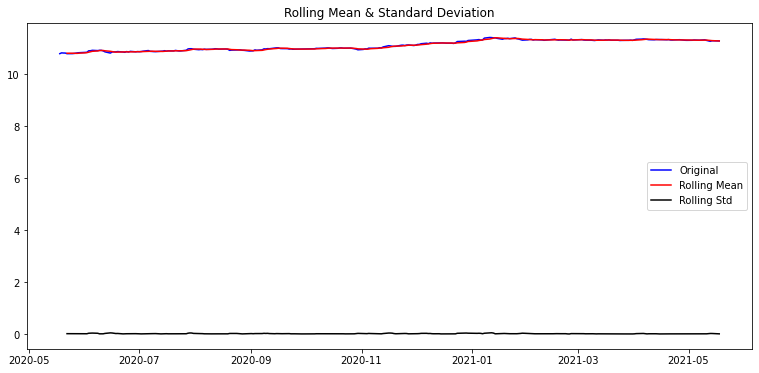

In [11]:
plot_rolling_statistics(ts_log, window=5)

### 정량적 Augmented Dicky-Fuller Test

In [12]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


### 시계열 분해 (Time Series Decomposition)

In [13]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

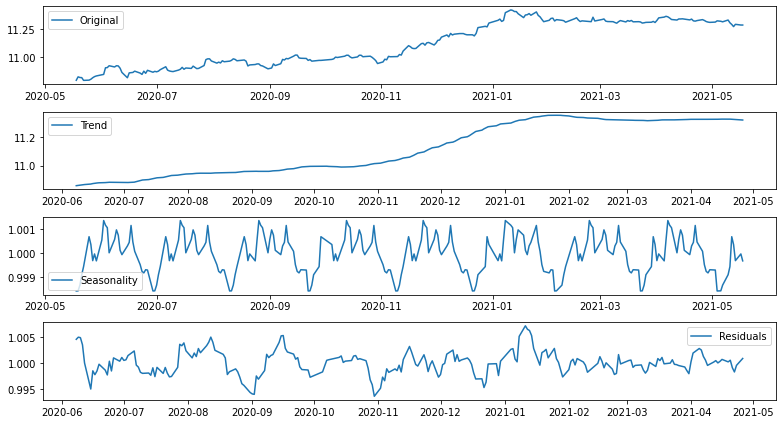

In [14]:
plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Residual 안정성 확인

In [15]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


In [34]:
def decompositionTs(ts_log):
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.rcParams["figure.figsize"] = (11,6)
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    return [trend, seasonal, residual]

---
# 데이터 분리

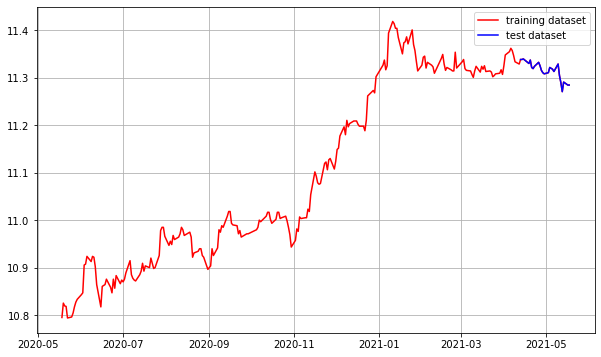

In [17]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [18]:
def getTrainTestData(ts_log):
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    
    return [train_data, test_data]

---

# 적정 ARIMA 모수 찾기

### ACF, PACF 그려보기 -> p,q 구하기

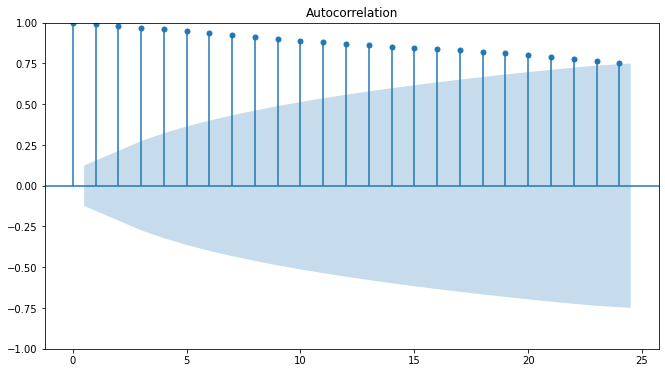

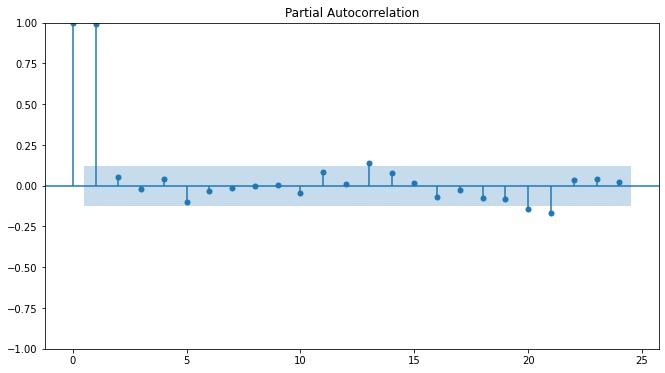

In [19]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

### 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


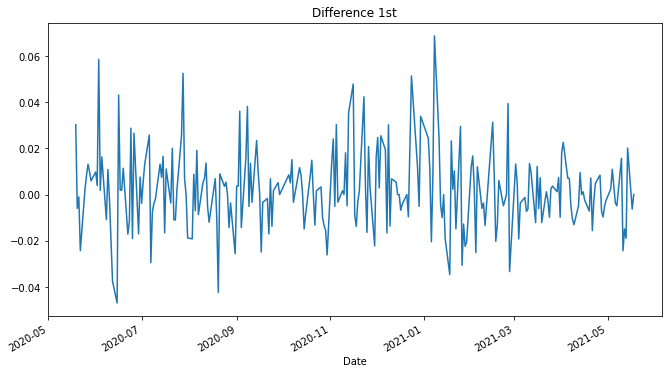

In [20]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [21]:
# # 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

In [42]:
def findARIMAargu(ts_log, diff_cnt, lags=25):
    plot_acf(ts_log, lags=lags)
    plot_pacf(ts_log, lags=lags)
    plt.show()
    
    diff_result = ts_log
    
    for i in range(diff_cnt):
        diff_result = diff_result.diff(periods=1).iloc[1:]

    diff_result.plot(title='Difference')
    augmented_dickey_fuller_test(diff_result)

---

# ARIMA 모델 훈련과 테스트

> ARIMA(p, d, q)

In [23]:
model = ARIMA(train_data, order=(2, 0, 0))
fitted_m = model.fit()

print(fitted_m.summary)

<bound method SARIMAXResults.summary of <statsmodels.tsa.arima.model.ARIMAResults object at 0x7f152bea8490>>


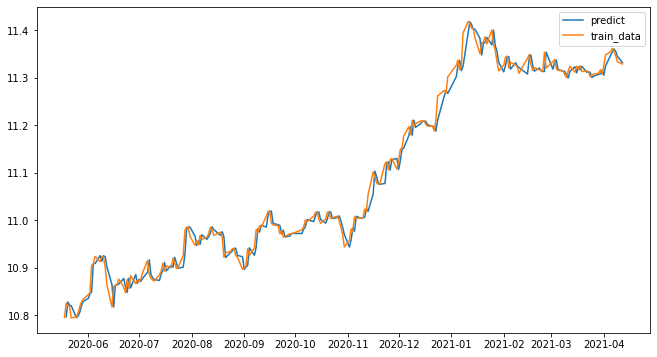

In [24]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])

plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

In [25]:
def trainModel(train_data, p, d, q):
    model = ARIMA(train_data, order=(p, d, q))
    fitted_m = model.fit()

    print(fitted_m.summary)
    
    return fitted_m

### Forecast

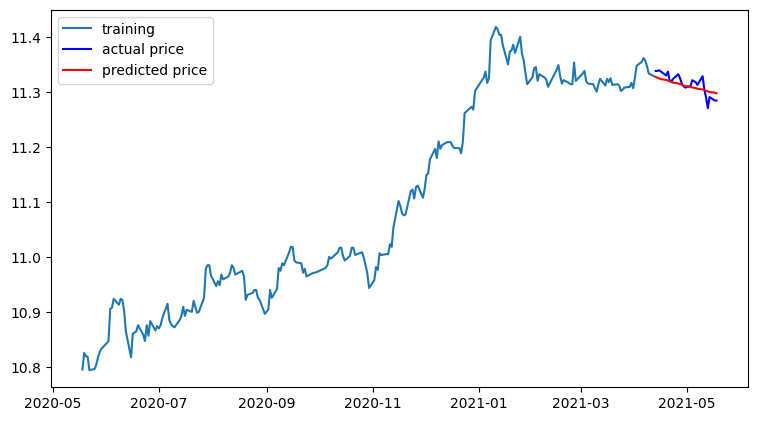

In [26]:
model = ARIMA(train_data, order=(2, 0, 0))
fitted_m = model.fit()

# forecast
fc = fitted_m.forecast(len(test_data), alpha=0.05)

# Make as pandas series
fc = np.array(fc)
fc_series = pd.Series(fc, index=test_data.index)

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [50]:
def forecast(fitted_m, train_data, test_data):
    # forecast
    fc = fitted_m.forecast(len(test_data), alpha=0.05)

    # Make as pandas series
    fc = np.array(fc)
    fc_series = pd.Series(fc, index=test_data.index)

    # Plot
    plt.figure(figsize=(9,5), dpi=100)
    plt.plot(np.exp(train_data), label='training')
    plt.plot(np.exp(test_data), c='b', label='actual price')
    plt.plot(np.exp(fc_series), c='r',label='predicted price')
    plt.legend()
    plt.show()
    
    return fc

### 테스트

In [28]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1052831.3953688445
MAE:  840.325291750654
RMSE:  1026.0757259427028
MAPE: 1.02%


In [29]:
def test(test_data, fc):
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

---

# 구글 주식에 적용

- 구글 주식 데이터 활용 : https://finance.yahoo.com/quote/GOOG/history?p=GOOG 

- PACF는 p-value를 넘어가는걸 기준으로 확인했습니다. 15 이후부터는 p-value 이내에 쭉 위치하므로 p=15으로 설정
- ACF는 p * q = 0 인 값으로 찾아, q=0 으로 설정
- 차분을 여러번 했을 때 1차 차분으로도 충분히 안정적이므로 d=1로 설정

Series([], Name: Close, dtype: float64)


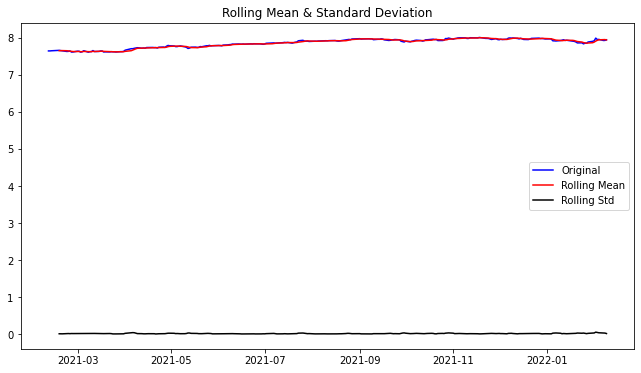

Results of Dickey-Fuller Test:
Test Statistic                  -1.622720
p-value                          0.471303
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


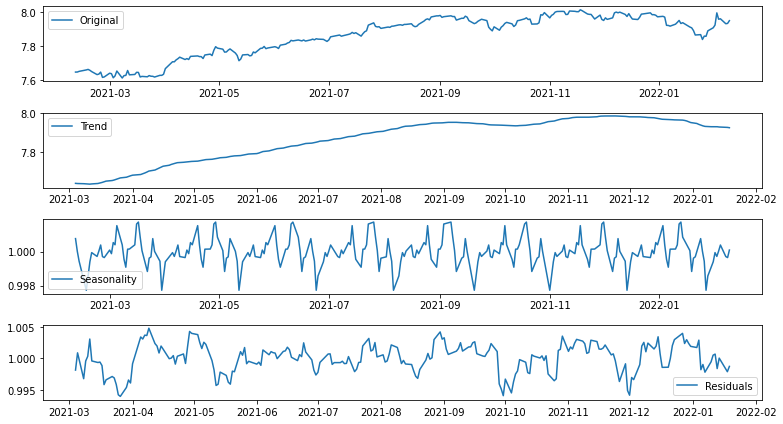

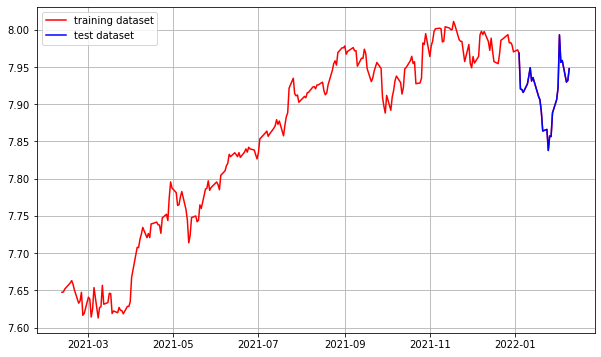

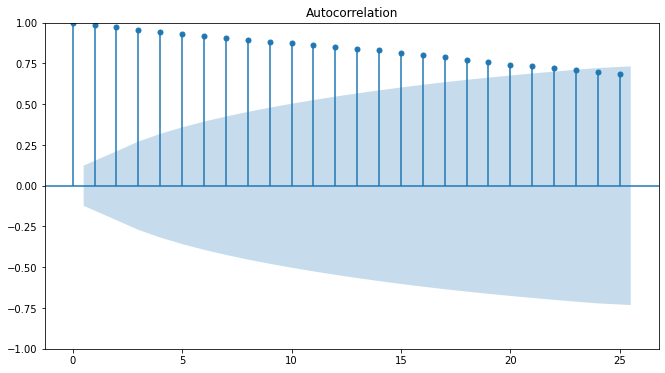

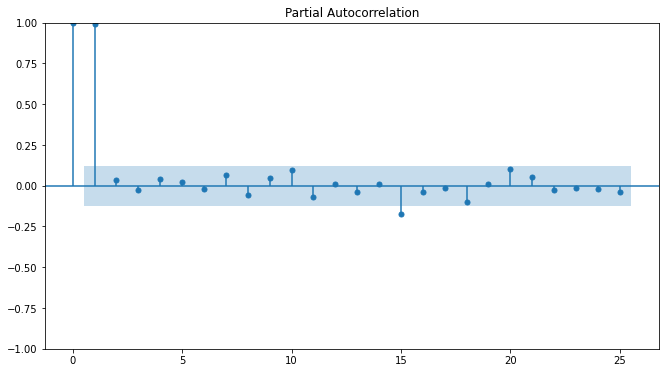

Results of Dickey-Fuller Test:
Test Statistic                -9.805433e+00
p-value                        5.843312e-17
#Lags Used                     2.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64
<bound method SARIMAXResults.summary of <statsmodels.tsa.arima.model.ARIMAResults object at 0x7f152da29340>>


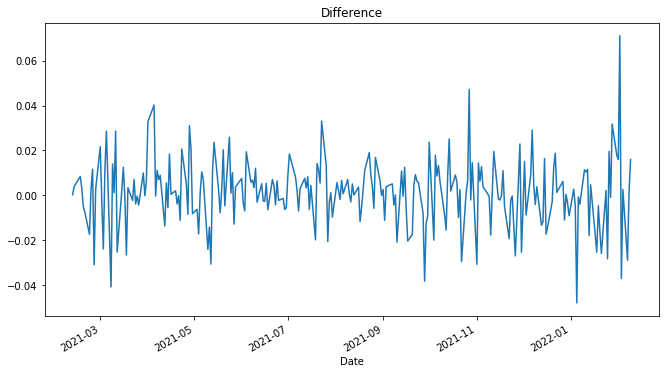

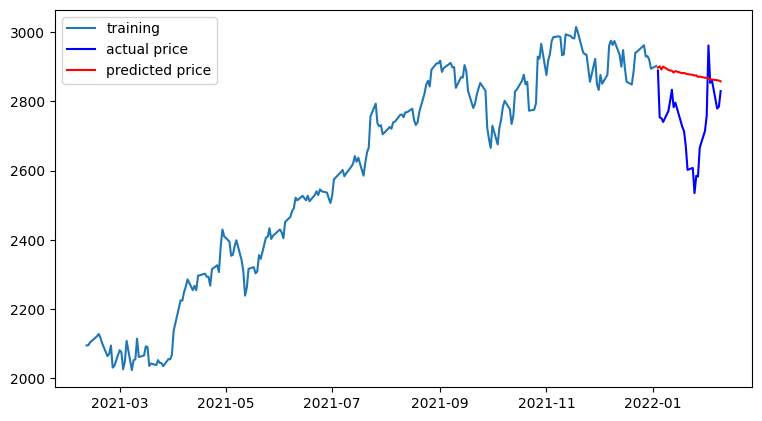

MSE:  28332.44443699123
MAE:  140.95654351288633
RMSE:  168.3224418697377
MAPE: 5.26%


In [54]:
goog_filepath = '/aiffel/stock_prediction/data/GOOG.csv' 
goog_ts = getData(goog_filepath)
# goog_ts.head()
# plt.plot(goog_ts)

goog_ts_log = preprocessing(goog_ts)
# plt.plot(goog_ts_log)

plot_rolling_statistics(goog_ts_log, window=5)

augmented_dickey_fuller_test(goog_ts_log)

goog_trend, goog_seasonal, goog_residual = decompositionTs(goog_ts_log)

goog_train_data, goog_test_data = getTrainTestData(goog_ts_log)

findARIMAargu(goog_ts_log, 1)

goog_fitted_m = trainModel(goog_train_data, 15, 0, 1)

goog_train_data

goog_fc = forecast(goog_fitted_m, goog_train_data, goog_test_data)

test(goog_test_data, goog_fc)

---

# 카카오 주식에 적용

- PACF는 p-value를 넘어가는걸 기준으로 확인했습니다. 21 이후부터는 p-value 이내에 쭉 위치하므로 p=21으로 설정
- ACF는 p * q = 0 인 값으로 찾아, q=0 으로 설정
- 차분을 여러번 했을 때 1차 차분으로도 충분히 안정적이므로 d=1로 설정

Series([], Name: Close, dtype: float64)


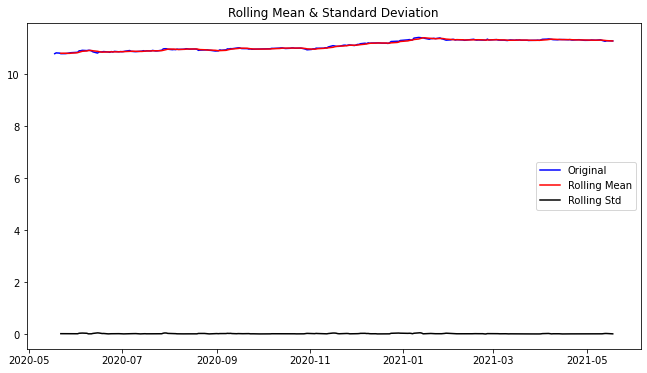

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


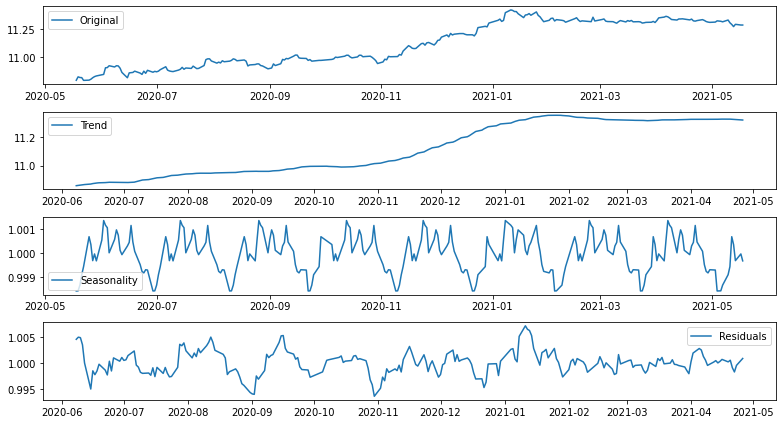

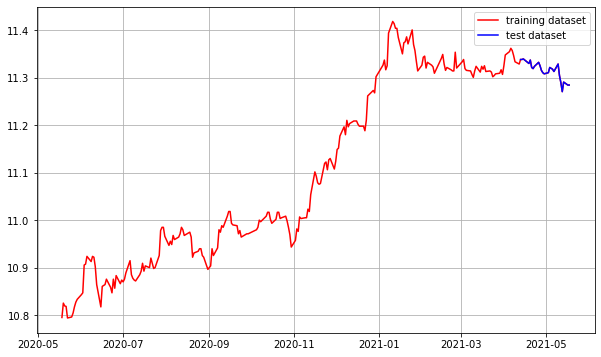

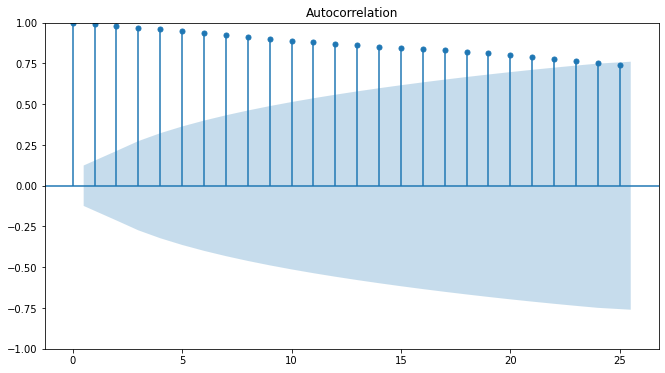

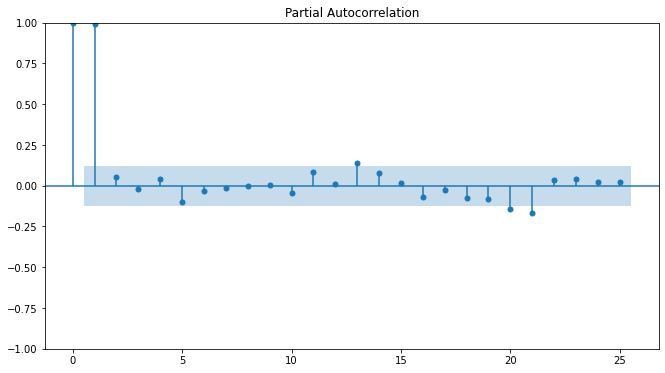

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
<bound method SARIMAXResults.summary of <statsmodels.tsa.arima.model.ARIMAResults object at 0x7f15299e7ac0>>


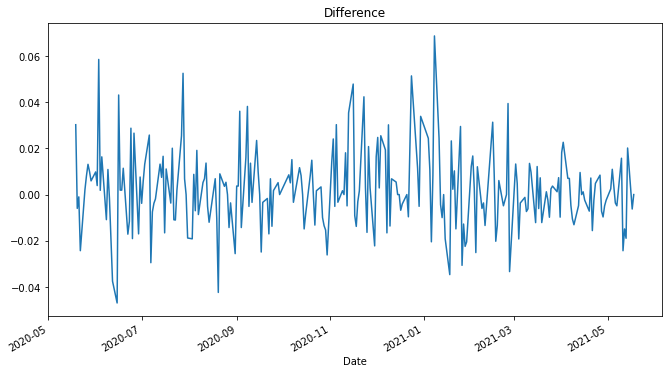

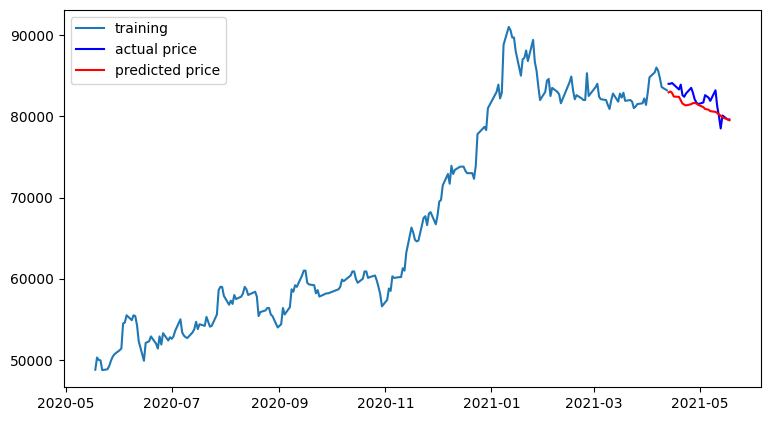

MSE:  1504290.692588941
MAE:  1025.3436604820222
RMSE:  1226.4952884495485
MAPE: 1.24%


In [53]:
kakao_filepath = '/aiffel/stock_prediction/data/005930.KS.csv' 
kakao_ts = getData(kakao_filepath)
# kakao_ts.head()
# plt.plot(kakao_ts)

kakao_ts_log = preprocessing(kakao_ts)
# plt.plot(kakao_ts_log)

plot_rolling_statistics(kakao_ts_log, window=5)

augmented_dickey_fuller_test(kakao_ts_log)

kakao_trend, kakao_seasonal, kakao_residual = decompositionTs(kakao_ts_log)

kakao_train_data, kakao_test_data = getTrainTestData(kakao_ts_log)

findARIMAargu(kakao_ts_log, 1)

kakao_fitted_m = trainModel(kakao_train_data, 21, 0, 1)

kakao_train_data

kakao_fc = forecast(kakao_fitted_m, kakao_train_data, kakao_test_data)

test(kakao_test_data, kakao_fc)

---

# 테슬라 주식에 적용

- PACF는 p-value를 넘어가는걸 기준으로 확인했습니다. 14 이후부터는 p-value 이내에 쭉 위치하므로 p=14으로 설정
- ACF는 p * q = 0 인 값으로 찾아, q=0 으로 설정
- 차분을 여러번 했을 때 1차 차분으로도 충분히 안정적이므로 d=1로 설정

Series([], Name: Close, dtype: float64)


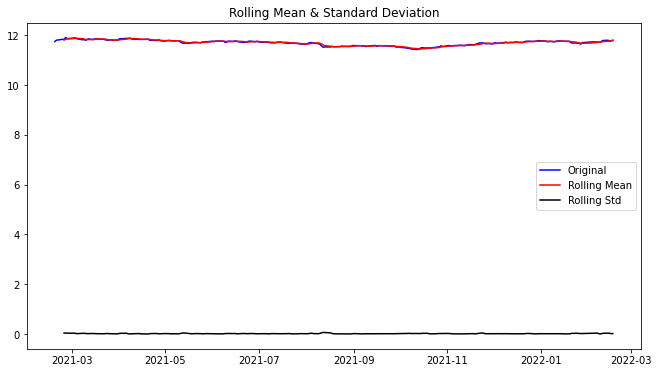

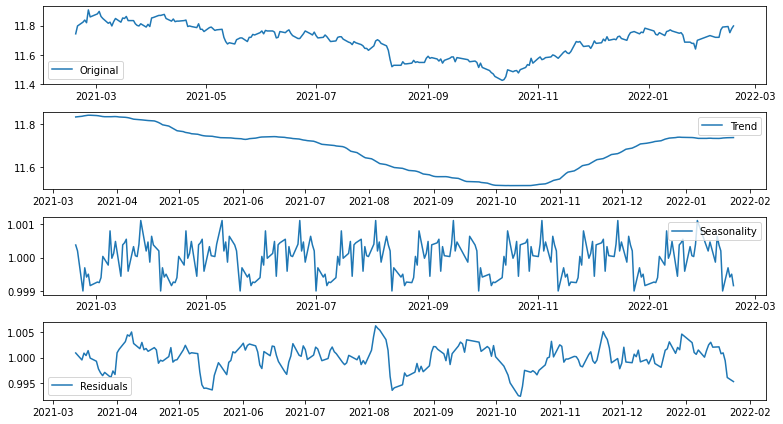

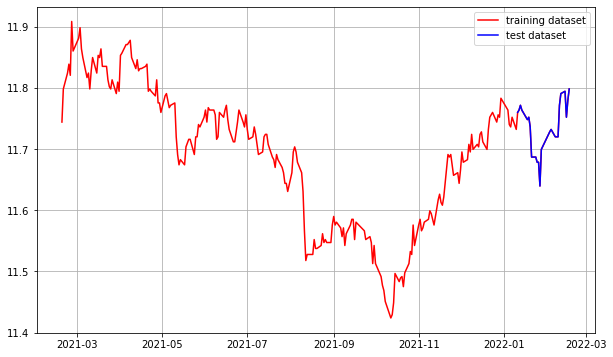

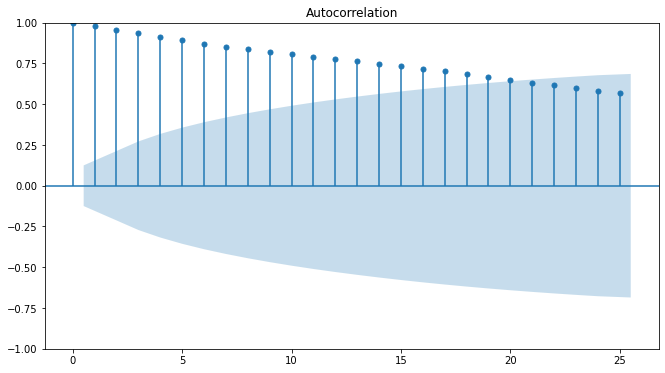

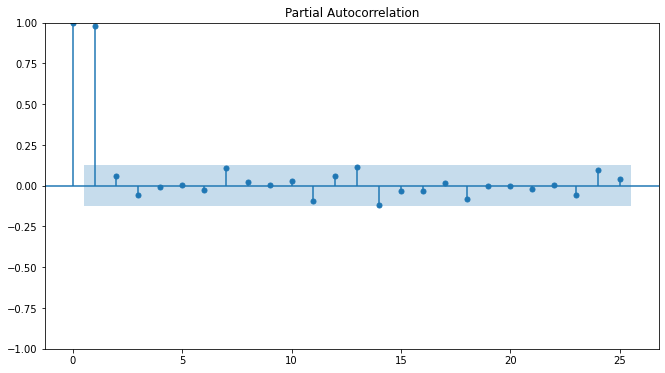

Results of Dickey-Fuller Test:
Test Statistic                -8.587451e+00
p-value                        7.440768e-14
#Lags Used                     1.100000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64
<bound method SARIMAXResults.summary of <statsmodels.tsa.arima.model.ARIMAResults object at 0x7f1529a24d30>>


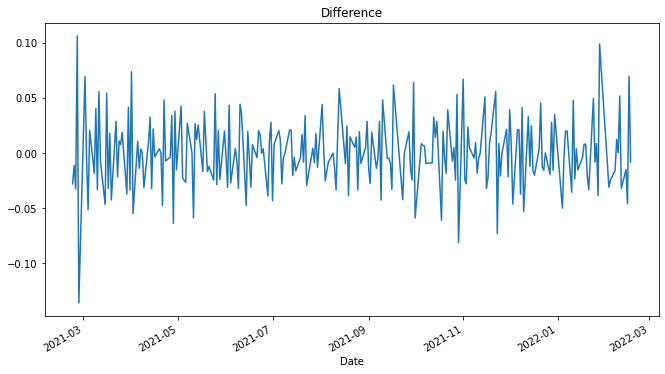

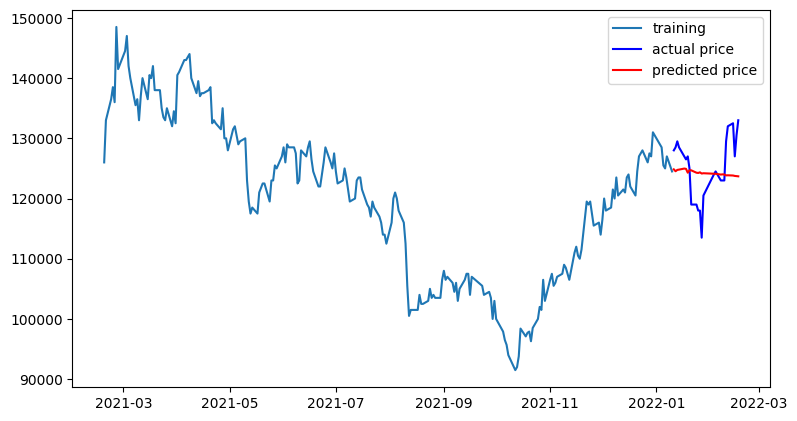

MSE:  26500523.105655275
MAE:  4215.8613799412915
RMSE:  5147.865878755513
MAPE: 3.37%


In [51]:
hynix_filepath = '/aiffel/stock_prediction/data/000660.KS.csv' 
hynix_ts = getData(hynix_filepath)
# hynix_ts.head()
# plt.plot(hynix_ts)

hynix_ts_log = preprocessing(hynix_ts)
# plt.plot(hynix_ts_log)

plot_rolling_statistics(hynix_ts_log, window=5)

hynix_trend, hynix_seasonal, hynix_residual = decompositionTs(hynix_ts_log)

hynix_train_data, hynix_test_data = getTrainTestData(hynix_ts_log)

findARIMAargu(hynix_ts_log, 2)

hynix_fitted_m = trainModel(hynix_train_data, 14, 0, 1)

hynix_train_data

hynix_fc = forecast(hynix_fitted_m, hynix_train_data, hynix_test_data)

test(hynix_test_data, hynix_fc)

In [52]:
np.exp(hynix_fc)

array([124846.04897269, 124534.69224587, 124751.77135067, 124803.00950509,
       124976.63765852, 124926.6881499 , 124291.14990276, 124693.60115639,
       124682.00851514, 124288.44310127, 124246.912737  , 124351.56341368,
       124151.48804659, 124201.04165571, 124119.00543769, 124110.87212842,
       123981.18001772, 124013.95317298, 123987.12982474, 123846.93247857,
       123859.03207401, 123822.34673432, 123753.07447204, 123722.11032767,
       123688.22426708])

---

# 회고

### 1. 어려웠던 점 혹은 아직 모호한 점
- 처음 접하는 통계 개념과 모델 설정이 어려워서 이해하는데 오래걸렸습니다


### 2. 시도한 것들
1. 정성적 표현을 하는데 있어서 수치를 바꿔봤습니다.
    - 주식에 요일을 탄다는 말을 들어본 적이 있어서, 장이 열리는 기준으로 window을 5로 설정해 보았습니다.
    - 삼성전자와 같은 경우는 분기마다 배당금을 주기 때문에, 이 부분이 영향을 미치지 않을까 싶어서 window 를 5 * 12 = 60으로 해보기도 했습니다만..
        - 그러나 이는 window를 너무 크게 잡아서 일일 그래프에 데이터가 너무 뭉치는 경향이 있어서 그래프에서 더 이상하게 그려지는 것을 확인할 수 있었습니다.
        - 이걸 적용하기 위해서는 일일 집계가 아니라 월별 집계로 데이터를 구성한 뒤에 시도해보면 좋을 것 같다고 생각했습니다.
2. 새로운 데이터에 대한 동일한 코드가 계속 반복돼서 함수화하여 처리했습니다.
3. pacf로 p값을 정할 때, 값이 갑자기 0으로 수렴하는 지점을 찾기 보다 "p-value를 벗어나지 않고 & 0으로 가까워지는 시점"을 기준으로 설정했습니다. 그 결과, 다음과 같은 결과를 확인할 수 있었습니다.

    - 구글
        - MSE:  28332.44443699123
        - MAE:  140.95654351288633
        - RMSE:  168.3224418697377
        - MAPE: 5.26%
    - 카카오
        - MSE:  1504290.692588941
        - MAE:  1025.3436604820222
        - RMSE:  1226.4952884495485
        - MAPE: 1.24%
    - SK하이닉스
        - MSE:  26500523.105655275
        - MAE:  4215.8613799412915
        - RMSE:  5147.865878755513
        - MAPE: 3.37%


### 3. 자기 다짐 혹은 소감
```
처음으로 시계열 데이터를 처리하면서 통계 개념이 많이 부족하다 느끼긴 했지만, 흥미로운 개념들이 많아 재밌었습니다.
```